# Leveraging langgraph agents with Bedrock using retrival Grader- for 2 different vector stores. 

In [20]:
!pip install -U --quiet  langgraph langchain_community  

In [22]:
!pip install -U --quiet "unstructured[pdf]" nest-asyncio sagemaker-data-insights==0.4.0 

In [21]:
!pip install -U --quiet tiktoken chromadb langchain langchain-aws 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.32.84 requires botocore==1.34.84, but you have botocore 1.34.134 which is incompatible.


In [23]:
!pip install llama-index docutils --upgrade --no-cache-dir --force-reinstall --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.32.84 requires botocore==1.34.84, but you have botocore 1.34.134 which is incompatible.
awscli 1.32.84 requires docutils<0.17,>=0.10, but you have docutils 0.21.2 which is incompatible.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.6.0 which is incompatible.
sphinx 7.2.6 requires docutils<0.21,>=0.18.1, but you have docutils 0.21.2 which is incompatible.


In [111]:
import getpass
import os

def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)
_set_if_undefined("LANGCHAIN_API_KEY")
#_set_if_undefined("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")
os.environ["TAVILY_API_KEY"] = "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"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

In [25]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [29]:
import boto3
import json, re
from langchain_community.embeddings import BedrockEmbeddings
from chromadb import Documents, EmbeddingFunction, Embeddings
from langchain_community.embeddings.bedrock import BedrockEmbeddings
from llama_index.core import SimpleDirectoryReader, ServiceContext, StorageContext, VectorStoreIndex
#from llama_index.llms.huggingface import HuggingFaceLLM

class MyEmbeddingFunction(EmbeddingFunction):
    def __init__(self, client, region_name: str, model_id: str):
        self.embedder = BedrockEmbeddings(
            client=client,
            region_name=region_name,
            model_id=model_id
        )
    def embed_query(self, query: str) -> Embeddings:
        return self.embedder.embed_query(query)
    def embed_documents(self, documents: list[str]) -> Embeddings:
        return self.embedder.embed_documents(documents)

In [92]:
counter = 0

In [30]:
bedrock_runtime = boto3.client(
    service_name="bedrock-runtime",
    region_name="us-east-1",
)

In [36]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://docs.aws.amazon.com/bedrock/latest/studio-ug/bedrock-studio-user-guide.pdf",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0.2
)

text_splitter_2 = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)
doc_splits_2 = text_splitter_2.split_documents(docs_list)

# Choose from a set of embedding models hosted on Amazon Bedrock
# Provider  | Model Name                        | Model ID
# -------------------------------------------------------------------------------
# Amazon    | Titan Embeddings G1 - Text 1.x   | amazon.titan-embed-text-v1
# Amazon    | Titan Embedding Text v2 1.x       | amazon.titan-embed-text-v2:0
# Cohere    | Embed English 3.x                 | cohere.embed-english-v3
# Cohere   | Embed Multilingual 3.x           | cohere.embed-multilingual-v3

embedding_function1 = MyEmbeddingFunction(client = bedrock_runtime,
                                         region_name = "us-east-1",
                                         model_id="amazon.titan-embed-text-v1")

embedding_function2 = MyEmbeddingFunction(client = bedrock_runtime,
                                         region_name = "us-east-1",
                                         model_id="amazon.titan-embed-text-v2:0")



In [37]:
vectorstore1 = Chroma.from_documents(
    documents=doc_splits,
    embedding=embedding_function1,
    collection_name="rag-chroma1",
)
retriever1 = vectorstore1.as_retriever()


In [38]:
vectorstore2 = Chroma.from_documents(
    documents=doc_splits_2,
    embedding=embedding_function2,
    collection_name="rag-chroma2",
)

retriever2 = vectorstore2.as_retriever()

In [44]:
from langchain.prompts import PromptTemplate
from langchain_aws import ChatBedrock
from langchain_core.output_parsers import JsonOutputParser


llm = ChatBedrock(
    client = bedrock_runtime,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    model_kwargs={"temperature": 0.0},
)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "Bedrock KnowledgeBases use case"
docs = retriever2.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [46]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class RouteQuery(BaseModel):
    
    datasource: Literal["vectorstore1", "vectorstore2"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )
    
llm = llm
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore1 or vectorstore2.
The vectorstore contains documents related to Bedrock agents,Bedrock prompt engineering, user-guide .
Use the vectorstore for questions on these topics. if not ablet to pick from vectorstore1 use vectorstore2."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "list of regions where Bedrock is available?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='vectorstore1'
datasource='vectorstore1'


In [51]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "What is Amazon Bedrock??"
docs = retriever1.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

docs2 = retriever2.get_relevant_documents(question)
doc_txt1 = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'
binary_score='yes'


In [52]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Amazon Bedrock is a service from Amazon that allows developers to build and deploy applications. It includes Amazon Bedrock Studio, which is a development environment for building applications using Amazon Bedrock.


In [53]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='no')

In [54]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call

structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [55]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'An improved question for better vectorstore retrieval could be:\n\n"What is Amazon Bedrock and what are its key features and use cases?"\n\nThis reformulated question aims to retrieve more comprehensive information about Amazon Bedrock, including its definition, key characteristics, and potential applications or use cases. By expanding the query beyond just asking what it is, the vectorstore is more likely to return relevant and detailed information that can provide a thorough understanding of the topic.'

In [112]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [116]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [133]:
from langchain.schema import Document


def retrieve1(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever1.invoke(question)
    return {"documents": documents, "question": question}

def retrieve2(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever1.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}



"""def web_search(state):
    
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results


    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}"""


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "vectorstore2":
        print("---ROUTE QUESTION TO VECTOR STORE 2---")
        return "vectorstore2"
    elif source.datasource == "vectorstore1":
        print("---ROUTE QUESTION TO VECTOR STORE 1---")
        return "vectorstore1"
    elif source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print(state["documents"])
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]



    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [134]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [144]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve2", retrieve2)  # retrieve2
workflow.add_node("retrieve1", retrieve1)  # retrieve1
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "vectorstore2": "retrieve2",
        "vectorstore1": "retrieve1",
        "web_search": "web_search", #replace with retriever 3
    },
)
workflow.add_edge("retrieve2", "grade_documents") #use Fmeval grader bind it as tools 
workflow.add_edge("retrieve1", "grade_documents")
workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve2")


workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

In [141]:
from pprint import pprint

# Run
inputs = {
    "question": "What is Amazon Bedrock?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO VECTOR STORE 1---
---RETRIEVE---
"Node 'retrieve1':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
[Document(page_content='Amazon Bedrock, Amazon Bedrock Studio, bedrock\nApache FOP Version 2.6\n1.4\n\n\nAWS\napplication/pdf\nAmazon Bedrock Studio - User Guide\nen\n2024-06-26T20:56:36Z\n\n\n1\n\n\nZonBook XSL Stylesheets with Apache FOP\n2024-06-26T20:56:36Z\n2024-06-26T20:56:36Z', metadata={'source': 'https://docs.aws.amazon.com/bedrock/latest/studio-ug/bedrock-studio-user-guide.pdf'}), Document(page_content='%PDF-1.4\n%����\n1 0 obj\n<<\n/Title (Amazon Bedrock Studio - User Guide)\n/Author (AWS)\n/Keywords (Amazon Bedrock, Amazon Bedrock Studio, bedrock)\n/Creator (ZonBook XSL Stylesheets with Apache FOP)\n/Producer (Apache FOP Version 2.6)\n/CreationDate (D:20240626205636Z)\n>>\nendobj\n2 0 obj\n<<\n  /N 3\n 

In [142]:
inputs = {
    "question": "What are the Supported AWS Regions for AWS Bedrock?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO VECTOR STORE 1---
---RETRIEVE---
"Node 'retrieve1':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
[]
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'


KeyError: 'generation'

In [76]:
##Currently it times out after 25 recursions and if it is not able to find the transform query then it returns the error

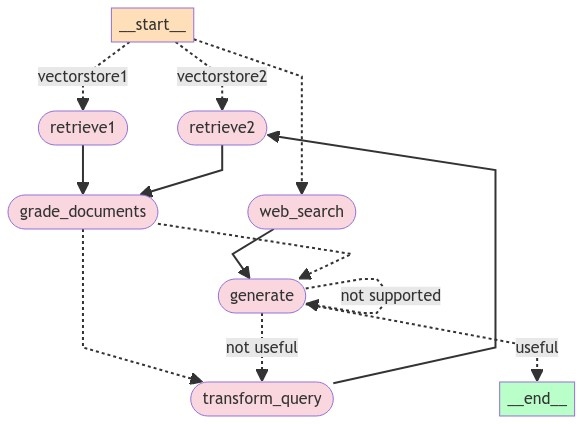

In [145]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))